In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# bin edges for open, high, low, close prices 
open_edges = np.array([-0.13728632, -0.00699993, -0.00268759, -0.00043515, 
                       0.00100485, 0.00337452, 0.00769464, 0.12093023])/100
high_edges = np.array([-1.24500692e-01, -5.33032969e-03, -2.00361804e-03, -3.01042205e-04, 
                       2.64360971e-05, 1.97052252e-03, 5.86654641e-03, 1.53449933e-01])/100
low_edges = np.array([-0.20508744, -0.00575599, -0.00147773, 0., 
                      0.00088992, 0.00279594, 0.00673527, 0.13863532])/100
close_edges = np.array([-0.13756105, -0.00710635, -0.00275844, -0.00042742, 
                        0.00100262, 0.00339668, 0.00777585, 0.12093023])/100

In [2]:
dir_path = './data/'
df = pd.read_pickle(dir_path+'df_hourly_BTC_with_test_prediction.pickle')
df = df.dropna()

df['time'] = df.index
df['date'] = df['time'].apply(mdates.date2num) # format required by candlestick_ohlc
# argument for candlestick_ohlc: sequence of (time, open, close, high, low, …) sequences
df = df[['date', 'USDT_BTC_open', 'USDT_BTC_high', 'USDT_BTC_low', 'USDT_BTC_close']]

# select a period of interest from the test set (24 hours after the first seq_len)
seq_len = 10
df_truth = df.iloc[-1996+seq_len:-1996+24+seq_len] 

df_truth.head()

,date,USDT_BTC_open,USDT_BTC_high,USDT_BTC_low,USDT_BTC_close
time,,,,,
2018-01-21 10:00:00,736715.416667,11684.552892,11907.555844,11656.548459,11778.457378
2018-01-21 11:00:00,736715.458333,11778.457378,12134.956696,11778.457378,12134.956696
2018-01-21 12:00:00,736715.500000,12135.295263,12253.428843,11945.428891,11946.000002
2018-01-21 13:00:00,736715.541667,11954.999998,12171.680000,11922.428891,11983.221492
2018-01-21 14:00:00,736715.583333,11986.786922,12050.000000,11650.000000,11729.930004


In [3]:
# include one hour before the start of the period of interest
df2 = pd.read_pickle(dir_path+'df_hourly_BTC_with_test_prediction.pickle').iloc[-1996+seq_len-1:]

df2['time'] = df2.index
df2['date'] = df2['time'].apply(mdates.date2num) # format required by candlestick_ohlc

# get price at previous timestep
df2['USDT_BTC_open_prev'] = df2['USDT_BTC_open'].shift(1)
df2['USDT_BTC_close_prev'] = df2['USDT_BTC_close'].shift(1)
df2['USDT_BTC_high_prev'] = df2['USDT_BTC_high'].shift(1)
df2['USDT_BTC_low_prev'] = df2['USDT_BTC_low'].shift(1)
df2 = df2.iloc[1:] # drop the first hour outside the period of interest

pred_cols = [col for col in df2.columns if 'pred' in col]
# for labels: float to int 
df2[pred_cols] = df2[pred_cols].astype(int)

df2[pred_cols].head()

,open_pctChange_predict,close_pctChange_predict,high_pctChange_predict,low_pctChange_predict
time,,,,
2018-01-21 10:00:00,0,6,0,0
2018-01-21 11:00:00,6,0,6,6
2018-01-21 12:00:00,6,0,6,6
2018-01-21 13:00:00,0,0,0,0
2018-01-21 14:00:00,4,0,6,6


In [4]:
# predict price at the next timestep based on pctChange classification label
df2['open_predict'] = df2['USDT_BTC_open_prev'] * \
                    (1 + (open_edges[df2['open_pctChange_predict']] + open_edges[df2['open_pctChange_predict']+1])/2)
df2['close_predict'] = df2['USDT_BTC_close_prev'] * \
                    (1 + (close_edges[df2['close_pctChange_predict']] + close_edges[df2['close_pctChange_predict']+1])/2)
df2['high_predict'] = df2['USDT_BTC_high_prev'] * \
                    (1 + (high_edges[df2['high_pctChange_predict']] + high_edges[df2['high_pctChange_predict']+1])/2)
df2['low_predict'] = df2['USDT_BTC_low_prev'] * \
                    (1 + (low_edges[df2['low_pctChange_predict']] + low_edges[df2['low_pctChange_predict']+1])/2)

# argument for candlestick_ohlc: sequence of (time, open, close, high, low, …) sequences
df2 = df2[['date', 'open_predict', 'high_predict', 'low_predict', 'close_predict']]

# prediction for the period of interest 
df_pred = df2.iloc[:24]
df_pred.head()

,date,open_predict,high_predict,low_predict,close_predict
time,,,,,
2018-01-21 10:00:00,736715.416667,11841.550970,11842.407450,11587.771081,11661.052308
2018-01-21 11:00:00,736715.458333,11692.067513,11917.041193,11665.021056,11769.937584
2018-01-21 12:00:00,736715.500000,11786.032391,12144.623189,11787.018584,12126.179033
2018-01-21 13:00:00,736715.541667,12126.540482,12245.474468,11932.835815,11937.359018
2018-01-21 14:00:00,736715.583333,11955.261775,12181.375746,11931.094743,11974.553584


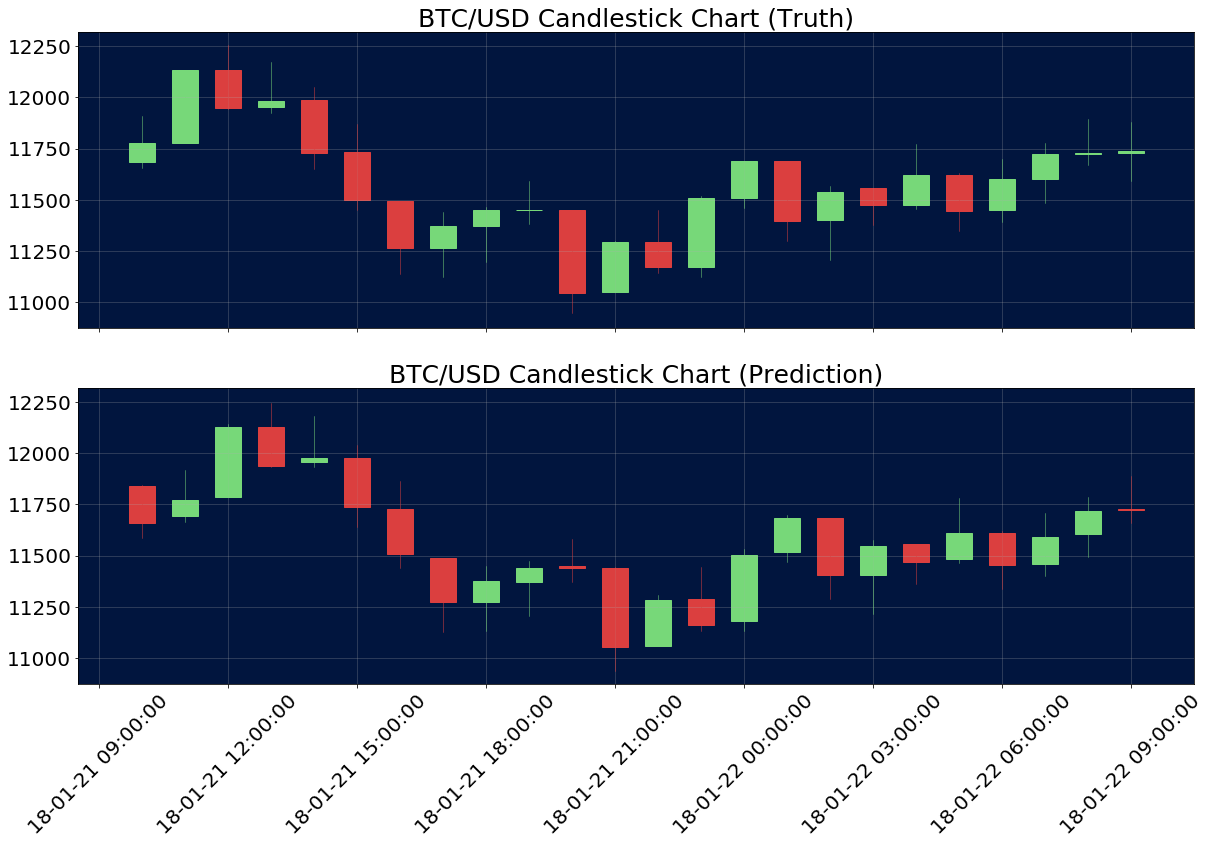

In [6]:
fig = plt.figure()
fig.set_size_inches(20, 12)

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharey=ax1) # use same yscale for truth and prediction

# use green candlestick where close >= open, red where close < open
candlestick_ohlc(ax1, df_truth.values, width=0.025, colorup='#77d879', colordown='#db3f3f', alpha=1)
candlestick_ohlc(ax2, df_pred.values, width=0.025, colorup='#77d879', colordown='#db3f3f', alpha=1)

ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M:%S'))
ax1.set_facecolor('xkcd:navy')
ax1.grid(True,alpha=0.3)
ax1.set_title('BTC/USD Candlestick Chart (Truth)', fontsize=25)

# hide xtick label for the first subplot 
labels = [item.get_text() for item in ax1.get_xticklabels()]
empty_string_labels = ['']*len(labels)
ax1.set_xticklabels(empty_string_labels)

ax2.xaxis_date()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M:%S'))
ax2.set_facecolor('xkcd:navy')
ax2.grid(True,alpha=0.3)
ax2.set_title('BTC/USD Candlestick Chart (Prediction)', fontsize=25)

plt.xticks(rotation=45)

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

plt.savefig('candle.eps', format='eps', dpi=1000, bbox_inches='tight')